In [7]:
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import jax.numpy as jnp
from jax import random, grad, jit, lax, jacrev
from jax.scipy.linalg import inv, svd, eigh, det
from jax.numpy.linalg import norm
from tqdm.auto import tqdm
from sklearn.datasets import make_spd_matrix
from jax_models import visualize_observations, Lorenz96, KuramotoSivashinsky, generate_true_states, generate_localization_matrix
from jax_filters import ensrf_steps, kalman_filter_process, ensrf_step
import jax
import matplotlib.pyplot as plt
from jax.tree_util import Partial
from functools import partial
from jax_vi import KL_gaussian, log_likelihood, KL_sum

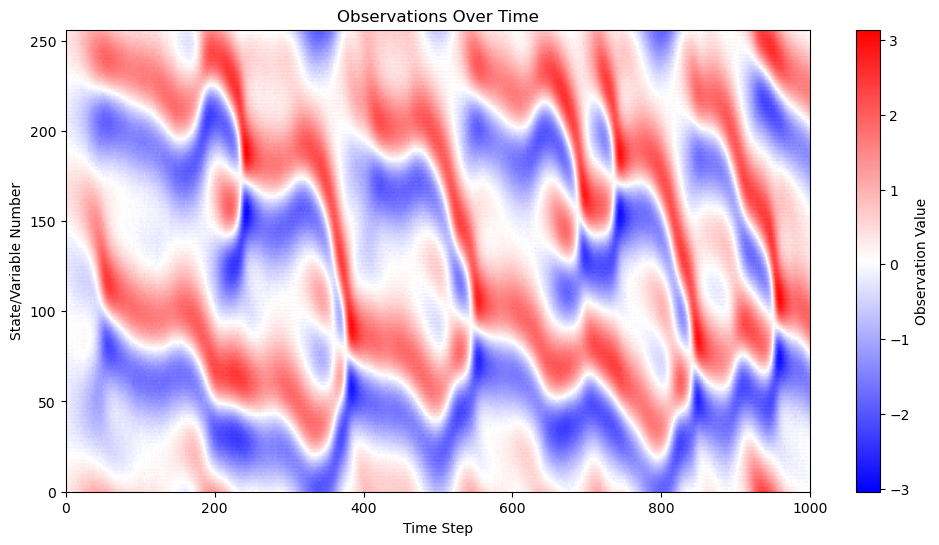

In [8]:
# Initialize parameters
N = 10 # number of Monte Carlo samples

num_steps = 1000  # Number of simulation steps
n = 256 # Dimensionality of the state space for KS model
observation_interval = 5  # Interval at which observations are made
dt = 0.25  # Time step for the KS model
J0 = 0
ks_model = KuramotoSivashinsky(dt=dt, s=n, l=22, M=16)

# Initial state
key = random.PRNGKey(0)  # Random key for reproducibility
x0 = random.normal(key, (n,))
initial_state  = x0
# Noise covariances
Q = 0.01 * jnp.eye(n)  # Process noise covariance
R = 0.5 * jnp.eye(n)  # Observation noise covariance
# Observation matrix (identity matrix for direct observation of all state variables)
H = jnp.eye(n)
# Generate observations
ks_step = Partial(ks_model.step)
state_transition_function = ks_step
observations, true_states = generate_true_states(key, num_steps, n, x0, H, Q, R, ks_step, observation_interval)

# Visualize the observations
visualize_observations(true_states)

In [9]:
@jit
def var_cost(radius, inflation, model, ensemble_init, observations, H, Q, R, key, J, J0):
    localization_matrix = generate_localization_matrix(n, radius)
    pred_states, pred_covariances, states, covariances = ensrf_steps(ks_step, ensemble_init, num_steps, observations, observation_interval, H, Q, R, localization_matrix, inflation, key)
    ensemble_mean = jnp.mean(states, axis=-1)  # Taking the mean across the ensemble members dimension
    ensemble_mean_pred = jnp.mean(pred_states, axis=-1)
    key, *subkeys = random.split(key, num=N+1)
    kl_sum = KL_sum(ensemble_mean_pred, pred_covariances, ensemble_mean, covariances, n, state_transition_function, Q, key)
    def inner_map(subkey):
        return log_likelihood(random.multivariate_normal(subkey, ensemble_mean, covariances), observations, H, R, J, J0)  
    cost = kl_sum - jnp.mean(jax.lax.map(inner_map, jnp.vstack(subkeys)))
    return cost

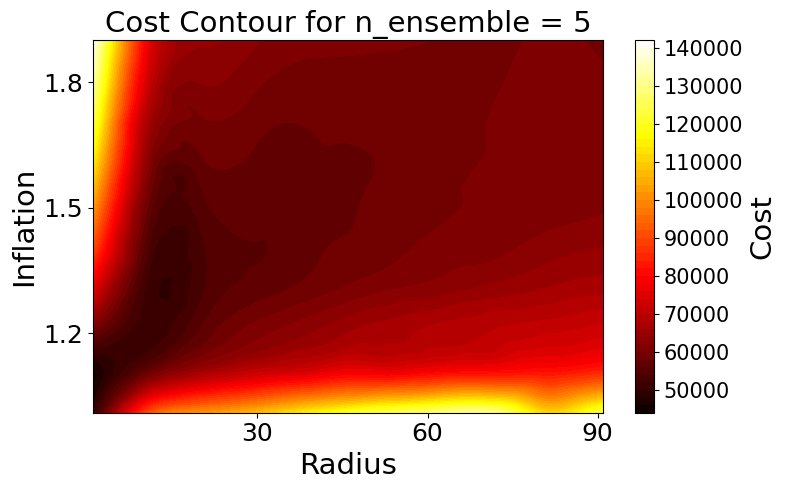

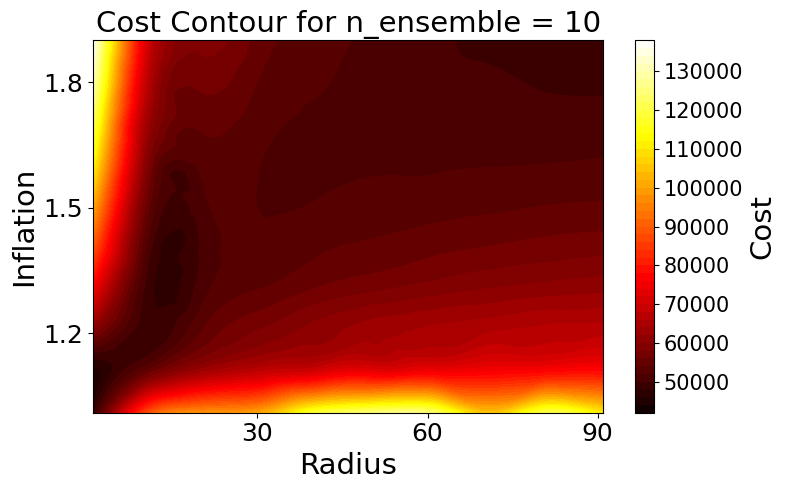

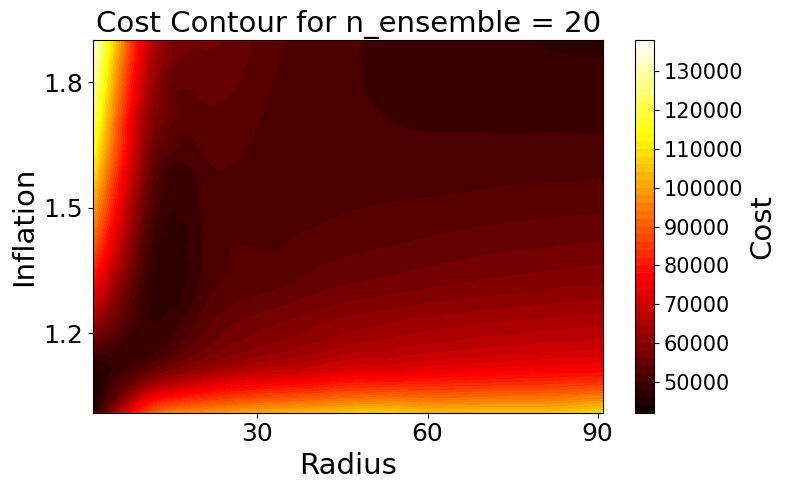

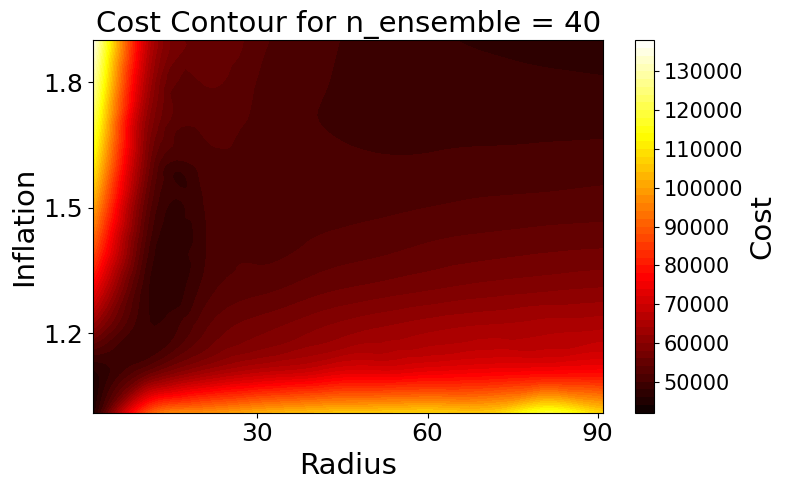

In [16]:
import pickle

for n_ensemble in [5,10,20,40]:
    with open('./ensemble_surface_results/ks_ensemble' + str(n_ensemble) + '_data_range100.pkl', 'rb') as file:
        loaded_results = pickle.load(file)
    
    data = loaded_results[0]
    
    plot_cost_contours(loaded_results, scaling=1.5, max_n_locator=3, prefix = 'KS')


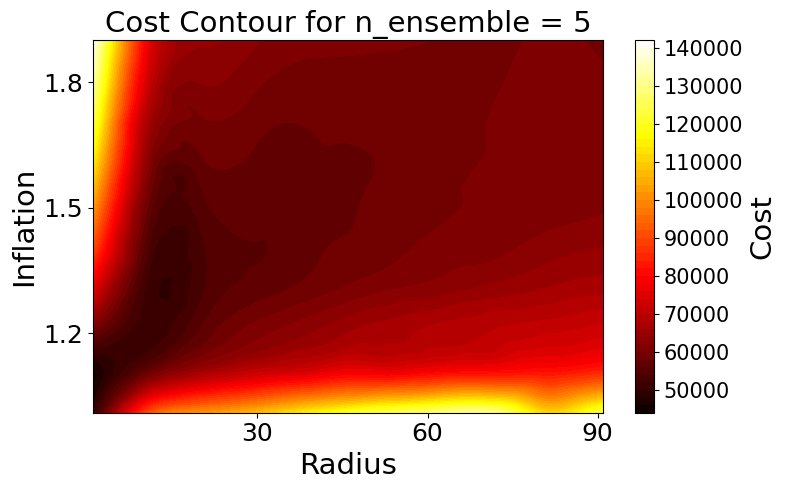

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pickle

def plot_cost_contours(loaded_results, scaling=1.0, max_n_locator=5, prefix = ''):
        data = loaded_results[0]
        radius_values, inflation_values, cost_values = data[:, 0], data[:, 1], data[:, 2]

        grid_radius, grid_inflation = np.mgrid[min(radius_values):max(radius_values):100j, min(inflation_values):max(inflation_values):100j]

        grid_cost = griddata((radius_values, inflation_values), cost_values, (grid_radius, grid_inflation), method='cubic')

        plt.figure(figsize=(8, 5))
        cp = plt.contourf(grid_radius, grid_inflation, grid_cost, levels=50, cmap='hot')
        cbar = plt.colorbar(cp)
        cbar.set_label('Cost', fontsize=14*scaling)
        cbar.ax.tick_params(labelsize=10*scaling)
        ticks = range(int(grid_cost.min() // 10000 * 10000) + 10000, int(grid_cost.max() // 10000 * 10000) + 10000, 10000)
        cbar.set_ticks(ticks)



        plt.xlabel('Radius', fontsize=14*scaling)
        plt.ylabel('Inflation', fontsize=14*scaling)
        plt.title(f'Cost Contour for n_ensemble = {n_ensemble}', fontsize=14*scaling)
        
        plt.xticks(fontsize=12*scaling)
        plt.yticks(fontsize=12*scaling)
        
        # reduce the number of x and y axis labels
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(max_n_locator))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))

        plt.tight_layout()
        plt.savefig(f'{prefix}_contour_plot_n_ensemble_{n_ensemble}.pdf')
        plt.show()
        plt.close()


# plot with scaling and max_n_locator parameters
plot_cost_contours(loaded_results, scaling=1.5, max_n_locator=3, prefix = 'KS')


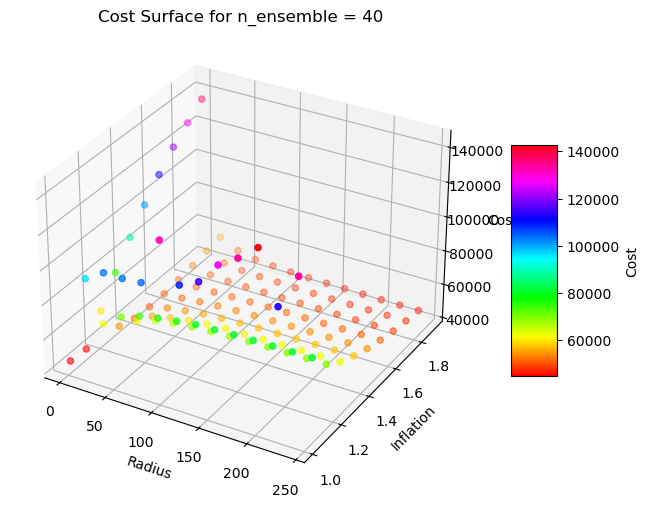

In [9]:
import pickle
with open('ks_ensemble20_data.pkl', 'rb') as file:
    loaded_results = pickle.load(file)

data = loaded_results[0]
radius_values, inflation_values, cost_values = data[:, 0], data[:, 1], data[:, 2]
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a 3D plot
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot using extracted data
scat = ax.scatter(radius_values, inflation_values, cost_values, c=cost_values, cmap='hsv', marker='o')
ax.set_xlabel('Radius')
ax.set_ylabel('Inflation')
ax.set_zlabel('Cost')
ax.set_title(f'Cost Surface for n_ensemble = {n_ensemble}')

# Adding a color bar to interpret the cost values more easily
color_bar = fig.colorbar(scat, ax=ax, shrink=0.5, aspect=5)
color_bar.set_label('Cost')

plt.show()

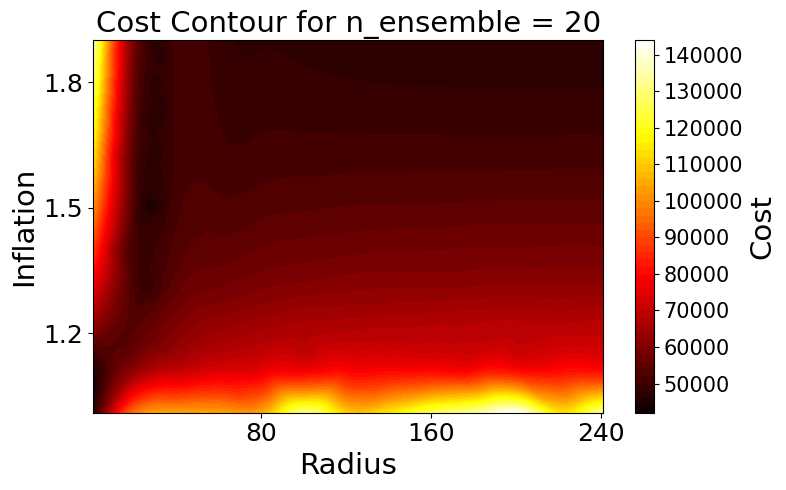

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pickle

def plot_cost_contours(loaded_results, ensemble_sizes, scaling=1.0, max_n_locator=5):
        data = loaded_results[0]
        radius_values, inflation_values, cost_values = data[:, 0], data[:, 1], data[:, 2]

        grid_radius, grid_inflation = np.mgrid[min(radius_values):max(radius_values):100j, min(inflation_values):max(inflation_values):100j]

        grid_cost = griddata((radius_values, inflation_values), cost_values, (grid_radius, grid_inflation), method='cubic')

        plt.figure(figsize=(8, 5))
        cp = plt.contourf(grid_radius, grid_inflation, grid_cost, levels=50, cmap='hot')
        cbar = plt.colorbar(cp)
        cbar.set_label('Cost', fontsize=14*scaling)
        cbar.ax.tick_params(labelsize=10*scaling)
        ticks = range(int(grid_cost.min() // 10000 * 10000) + 10000, int(grid_cost.max() // 10000 * 10000) + 10000, 10000)
        cbar.set_ticks(ticks)



        plt.xlabel('Radius', fontsize=14*scaling)
        plt.ylabel('Inflation', fontsize=14*scaling)
        plt.title(f'Cost Contour for n_ensemble = {n_ensemble}', fontsize=14*scaling)
        
        plt.xticks(fontsize=12*scaling)
        plt.yticks(fontsize=12*scaling)
        
        # reduce the number of x and y axis labels
        plt.gca().xaxis.set_major_locator(plt.MaxNLocator(max_n_locator))
        plt.gca().yaxis.set_major_locator(plt.MaxNLocator(max_n_locator))

        plt.tight_layout()
        plt.savefig(f'contour_plot_n_ensemble_{n_ensemble}.pdf')
        plt.show()
        plt.close()


# ensemble sizes
ensemble_sizes = [5]
n_ensemble = 20
# plot with scaling and max_n_locator parameters
plot_cost_contours(loaded_results, ensemble_sizes, scaling=1.5, max_n_locator=3)
